In [33]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# 历史天气部分

## 将经纬度找到指定的county

In [34]:
historical_weather = pd.read_csv("../data/historical_weather.csv",parse_dates=['datetime'])
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637


In [35]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [36]:
historical_weather['year'] = historical_weather['datetime'].apply(lambda x: x.year)
historical_weather['month'] = historical_weather['datetime'].apply(lambda x: x.month)
historical_weather['day'] = historical_weather['datetime'].apply(lambda x: x.day)
historical_weather['hour'] = historical_weather['datetime'].apply(lambda x: x.hour)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [37]:
historical_weather['latitude'] = historical_weather['latitude'].astype(float).round(1)
historical_weather['longitude'] = historical_weather['longitude'].astype(float).round(1)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [38]:
weather_to_county = pd.read_csv("../data/weather_station_to_county_mapping.csv")
weather_to_county

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [39]:
historical_weather.groupby(by=["longitude","latitude"])["data_block_id"].describe().unstack()


count                                                        \
latitude      57.6     57.9     58.2     58.5     58.8     59.1     59.4   
longitude                                                                  
21.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
28.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   

                          mean                                      \
latitude      59.7        57.6        57.9        58.2        58.5   
longitude                                                            
21.7       15275.0  319.270638  319.270638  319.270638  319.270638   
22.2       15275.0  319.270638  319.270638  319.270638  319.270638   
22.7       15275.0  319.270638  319.270638  319.270638  319.270638   
23.2       15275.0  319.270638  319.270638  319.270638  319.270638   
23.7       15275.0  319.270638  319.270638  319.270638  319.270638   
24.2       15275.0  319.270638  319.270638  319.270638  319.270638   
24.7       15275.0  319.270638  319.270638  319.270638  319.270638   
25.2       15275.0  319.270638  319.270638  319.270638  319.270638   
25.7       15275.0  319.270638  319.270638  319.270638  319.270638   
26.2       15275.0  319.270638  319.270638  319.270638  319.270638   
26.7       15275.0  319.270638  319.270638  319.270638  319.270638   
27.2       15275.0  319.270638  319.270638  319.270638  319.270638   
27.7       15275.0  319.270638  319.270638  319.270638  319.270638   
28.2       15275.0  319.270638  319.270638  319.270638  319.270638   

                                                                 std  \
latitude         58.8        59.1        59.4        59.7       57.6   
longitude                                                              
21.7       319.270638  319.270638  319.270638  319.270638  183.73582   
22.2       319.270638  319.270638  319.270638  319.270638  183.73582   
22.7       319.270638  319.270638  319.270638  319.270638  183.73582   
23.2       319.270638  319.270638  319.270638  319.270638  183.73582   
23.7       319.270638  319.270638  319.270638  319.270638  183.73582   
24.2       319.270638  319.270638  319.270638  319.270638  183.73582   
24.7       319.270638  319.270638  319.270638  319.270638  183.73582   
25.2       319.270638  319.270638  319.270638  319.270638  183.73582   
25.7       319.270638  319.270638  319.270638  319.270638  183.73582   
26.2       319.270638  319.270638  319.270638  319.270638  183.73582   
26.7       319.270638  319.270638  319.270638  319.270638  183.73582   
27.2       319.270638  319.270638  319.270638  319.270638  183.73582   
27.7       319.270638  319.270638  319.270638  319.270638  183.73582   
28.2       319.270638  319.270638  319.270638  319.270638  183.73582   

                                                                             \
latitude        57.9       58.2       58.5       58.8       59.1       59.4   
longitude                                                                     
21.7       183.73582  183.73582  183.73582  183.73582  183.73582  1

In [40]:
weather_to_county.groupby(by=["longitude","latitude"])["county"].describe().unstack().count()

       latitude
count  57.6        14
       57.9        14
       58.2        14
       58.5        14
       58.8        14
                   ..
max    58.5        11
       58.8         8
       59.1         9
       59.4         8
       59.7         0
Length: 64, dtype: int64

In [41]:
location = pd.read_csv("../data/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

location

,county,longitude,latitude
0,0,242,591
1,0,252,591
2,0,237,594
3,0,242,594
4,0,247,594
...,...,...,...
70,15,267,576
71,15,272,576
72,15,267,579
73,15,272,579


In [42]:
def process_weather_info(h, location=location) :

    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)

    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # Fill NaN and force int
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return
    return h

In [43]:
historical_weather = process_weather_info(historical_weather)
historical_weather
#成功将经纬度找到county

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour,county
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,576,217,1,2021,9,1,0,-1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,576,222,1,2021,9,1,0,-1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,576,227,1,2021,9,1,0,-1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,576,232,1,2021,9,1,0,10
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,576,237,1,2021,9,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,597,262,637,2023,5,30,10,5
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,597,267,637,2023,5,30,10,5
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,597,272,637,2023,5,30,10,-1
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,597,277,637,2023,5,30,10,-1


保存成新的csv，成功后就不运行了

In [44]:
# historical_weather.to_csv('../data/historical_weather_New.csv')

In [45]:
historical_weather = historical_weather.drop_duplicates(['data_block_id','county'])

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
train = pd.read_csv("../data/train.csv",parse_dates=['datetime'])
train['county'] = train['county'].astype(int)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27


In [48]:
train['year'] = train['datetime'].apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['day'] = train['datetime'].apply(lambda x: x.day)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25,2022,8,2,20
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25,2022,8,2,20
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27,2022,8,2,20
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27,2022,8,2,20


In [49]:
train_new= train[['county', 'data_block_id', 'target','is_consumption','is_business','product_type','hour']]
train_new_is_consumption = train_new[train_new['is_consumption']==1]
train_new_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour
1,0,0,96.590,1,0,1,0
3,0,0,17.314,1,0,2,0
5,0,0,656.859,1,0,3,0
7,0,0,59.000,1,1,0,0
9,0,0,501.760,1,1,1,0
...,...,...,...,...,...,...,...
1048565,5,335,70.632,1,1,1,20
1048567,5,335,676.373,1,1,3,20
1048569,6,335,217.705,1,1,3,20
1048571,7,335,46.429,1,0,1,20


In [50]:
train_group_by = train.groupby('county')['target'].describe()
train_group_by

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
0,111386.0,825.153596,2025.957999,0.0,0.59400,49.5170,486.45450,13896.422
1,48354.0,34.586789,54.362684,0.0,0.14200,11.7590,51.80975,435.548
2,57178.0,165.276639,454.781636,0.0,0.11600,17.3470,67.86225,3036.604
3,64472.0,149.659002,284.397083,0.0,0.01500,30.3975,106.64050,1702.566
4,74736.0,123.313065,202.551501,0.0,0.08700,18.3770,154.63000,1248.623
5,79102.0,221.358705,361.202753,0.0,0.90300,51.4800,199.71750,1894.246
6,16118.0,62.189757,67.177602,0.0,0.00500,40.9170,120.59825,269.434
7,91095.0,174.789969,277.250895,0.0,0.20400,41.6850,233.49300,1682.319
8,48348.0,64.331945,99.989932,0.0,0.11400,17.2795,81.71350,627.347


In [51]:
merged_is_consumption = pd.merge(train_new_is_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [52]:
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,96.590,1,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,17.314,1,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,656.859,1,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,59.000,1,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,501.760,1,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524282,5,335,70.632,1,1,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524283,5,335,676.373,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524284,6,335,217.705,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524285,7,335,46.429,1,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
train_new_no_consumption = train_new[train_new['is_consumption']==0]

In [54]:
merged_no_consumption  = pd.merge(train_new_no_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [55]:
merged_no_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,0.713,0,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.000,0,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2.904,0,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.000,0,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.000,0,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524283,5,335,24.534,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524284,6,335,6.001,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524285,7,335,16.237,0,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524286,7,335,49.939,0,0,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
merged_is_consumption = merged_is_consumption .dropna()
merged_no_consumption = merged_no_consumption .dropna()
merged_no_consumption
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
1464,0,1,109.366,1,0,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1465,0,1,21.008,1,0,2,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1466,0,1,735.696,1,0,3,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1467,0,1,75.800,1,1,0,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1468,0,1,502.241,1,1,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523723,15,335,12.906,1,0,1,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523724,15,335,16.764,1,0,3,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523725,15,335,677.150,1,1,0,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523726,15,335,39.539,1,1,1,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0


# 开始计算相关性（以county=0，product_type=1为例子）
## 生产target的相关性
### 生产且商用和target的相关性

In [57]:
merged_is_consumption_is_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==1)]
merged_is_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id            -0.517820
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.033814
datetime                 -0.517845
temperature              -0.649957
dewpoint                 -0.537002
rain                     -0.135104
snowfall                  0.200046
surface_pressure         -0.220986
cloudcover_total          0.312041
cloudcover_low            0.372756
cloudcover_mid            0.118293
cloudcover_high           0.046511
windspeed_10m             0.081326
winddirection_10m        -0.037214
shortwave_radiation      -0.696586
direct_solar_radiation   -0.606428
diffuse_radiation        -0.688409
latitude                       NaN
longitude                      NaN
year                     -0.423142
month                     0.224056
day                      -0.041914
Name: target, dtype: float64

### 生产且非商用和target相关性

In [58]:
merged_is_consumption_no_business = merged_is_consumption[(merged_is_consumption['county']==0)&(merged_is_consumption['product_type']==1)&(merged_is_consumption['is_business']==0)]
merged_is_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id            -0.254746
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.029097
datetime                 -0.254763
temperature              -0.741181
dewpoint                 -0.640652
rain                     -0.101000
snowfall                  0.294615
surface_pressure         -0.410937
cloudcover_total          0.311660
cloudcover_low            0.349639
cloudcover_mid            0.186548
cloudcover_high           0.034303
windspeed_10m             0.095834
winddirection_10m        -0.002522
shortwave_radiation      -0.672770
direct_solar_radiation   -0.574496
diffuse_radiation        -0.694033
latitude                       NaN
longitude                      NaN
year                     -0.074624
month                    -0.107326
day                      -0.028584
Name: target, dtype: float64

### 有上图可知天气对商用和非商用用电的影响差别较低，生产用电都和温度，地表压力，辐射有高的相似度，和降雪，总体云层，最低云层具有较高相似度

### 消耗且非商用和target的相关性

In [59]:
merged_no_consumption_no_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==0)]
merged_no_consumption_no_business.corr().loc['target']

county                         NaN
data_block_id             0.756872
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.048885
datetime                  0.756878
temperature               0.603200
dewpoint                  0.437568
rain                      0.131214
snowfall                 -0.170011
surface_pressure          0.226435
cloudcover_total         -0.323466
cloudcover_low           -0.401883
cloudcover_mid           -0.108221
cloudcover_high          -0.019711
windspeed_10m            -0.226582
winddirection_10m        -0.040759
shortwave_radiation       0.772540
direct_solar_radiation    0.693803
diffuse_radiation         0.708131
latitude                       NaN
longitude                      NaN
year                      0.552337
month                    -0.221068
day                       0.056068
Name: target, dtype: float64

### 消耗且商用和target的相关性

In [64]:
merged_no_consumption_is_business = merged_no_consumption[(merged_no_consumption['county']==0)&(merged_no_consumption['product_type']==1)&(merged_no_consumption['is_business']==1)]
merged_no_consumption_is_business.corr().loc['target']

county                         NaN
data_block_id             0.655760
target                    1.000000
is_consumption                 NaN
is_business                    NaN
product_type                   NaN
hour                      0.043624
datetime                  0.655765
temperature               0.549414
dewpoint                  0.398838
rain                      0.131240
snowfall                 -0.168567
surface_pressure          0.195036
cloudcover_total         -0.279624
cloudcover_low           -0.368783
cloudcover_mid           -0.087145
cloudcover_high          -0.015645
windspeed_10m            -0.191976
winddirection_10m        -0.032914
shortwave_radiation       0.703120
direct_solar_radiation    0.629012
diffuse_radiation         0.650870
latitude                       NaN
longitude                      NaN
year                      0.475179
month                    -0.186160
day                       0.050228
Name: target, dtype: float64

<Axes: >

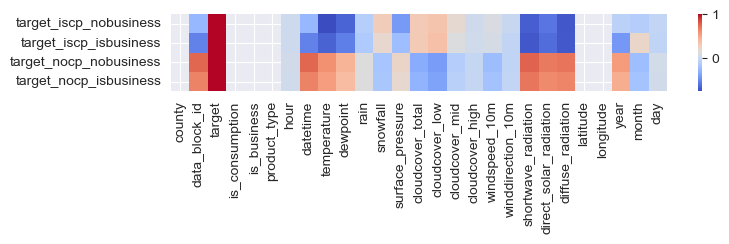

In [68]:
corr_no_consumption_is_business = merged_no_consumption_is_business.corr().loc['target']
corr_no_consumption_no_business = merged_no_consumption_no_business.corr().loc['target']
corr_is_consumption_is_business = merged_is_consumption_is_business.corr().loc['target']
corr_is_consumption_no_business = merged_is_consumption_no_business.corr().loc['target']
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business,
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

### 有上图可知天气对商用和非商用用电的影响差别较低，消耗电量都和温度，辐射有高的相似度，和总体云层，最低云层具有较高相似度

# 预测天气部分

In [47]:
# 读取数据
forcast_weather = pd.read_csv('../data/forecast_weather.csv', parse_dates=['forecast_datetime'])
forcast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 00:00:00+00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 00:00:00+00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 00:00:00+00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 00:00:00+00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 00:00:00+00:00,0.0,0.0,0.0,0.0


In [49]:
# 将经纬度乘以10并调整为整数型以减少内存占用
forcast_weather['latitude'] = forcast_weather['latitude']*10
forcast_weather['longitude'] = forcast_weather['longitude']*10
forcast_weather['latitude'] = forcast_weather['latitude'].astype(int)
forcast_weather['longitude'] = forcast_weather['longitude'].astype(int)
forcast_weather['hour'] = forcast_weather['forecast_datetime'].apply(lambda x: x.hour)
forcast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,hour
0,576,217,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
1,576,222,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
2,576,227,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
3,576,232,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1
4,576,237,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0,1


In [50]:
# 拼接前的预测天气数据
len(forcast_weather)

3424512

In [51]:
# 筛选hours_ahead小于24的数据，即预测跨度为一天的数据
forcast_weather = forcast_weather[forcast_weather['hours_ahead'] >= 24]
len(forcast_weather)

1783600

In [52]:
# 对数据按照经纬度拼接
forcast_weather = pd.merge(left=forcast_weather, right=location, on=['latitude', 'longitude'])
# forcast_weather.drop_duplicates(subset=['county', 'origin_datetime'], inplace=True)
forcast_weather['county'].unique()
# 经过观察拼接后的county缺少了12

array([10, 15,  7, 13, 14, 11,  8,  4,  1,  6,  9,  3,  0,  5,  2],
      dtype=int64)

In [53]:
train_with_forecast_weather = pd.merge(left=train, right=forcast_weather, on=['county', 'data_block_id', 'hour'], how='left')
train_with_forecast_weather.drop_duplicates(subset=['row_id'], inplace=True)
train_with_forecast_weather

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11263779,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263784,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263789,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0
11263794,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023,5,31,23,576.0,267.0,2023-05-30 00:00:00+00:00,47.0,9.185205,4.397241,0.570526,0.0,0.0,0.570526,3.161763,-0.698455,2023-05-31 23:00:00+00:00,0.0,0.0,0.0,0.0


In [54]:
len(train)

2018352

In [55]:
len(train_with_forecast_weather)

2018352

In [56]:
# 查看拼接后数据的缺失值情况
train_with_forecast_weather.isnull().sum()

county                                   0
is_business                              0
product_type                             0
target                                 528
is_consumption                           0
datetime                                 0
data_block_id                            0
row_id                                   0
prediction_unit_id                       0
year                                     0
month                                    0
day                                      0
hour                                     0
latitude                             33504
longitude                            33504
origin_datetime                      33504
hours_ahead                          33504
temperature                          33504
dewpoint                             33504
cloudcover_high                      33504
cloudcover_low                       33504
cloudcover_mid                       33504
cloudcover_total                     33504
10_metre_u_

In [57]:
# 删除缺失值
train_with_forecast_weather.dropna(how='any', inplace=True)
train_with_forecast_weather.drop(columns=['forecast_datetime', 'origin_datetime'], inplace=True)

## 生产电量与预测天气的相关性
以county=2, product_type=1为例

### 商业生产电量与预测天气的相关性

In [74]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_no_consumption_is_business = train_forecast_is_consumption.corr()['target']
corr_no_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.024407
data_block_id                        0.024219
row_id                               0.023588
prediction_unit_id                        NaN
year                                -0.003156
month                                0.040172
day                                  0.022450
hour                                 0.097135
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.097135
temperature                          0.528462
dewpoint                             0.268787
cloudcover_high                     -0.097232
cloudcover_low                      -0.307835
cloudcover_mid                      -0.133898
cloudcover_total                  

### 非商业生产电量与预测天气的相关性

In [75]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==0) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_no_consumption_no_business = train_forecast_is_consumption.corr()['target']
corr_no_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.024407
data_block_id                        0.024219
row_id                               0.023588
prediction_unit_id                        NaN
year                                -0.003156
month                                0.040172
day                                  0.022450
hour                                 0.097135
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.097135
temperature                          0.528462
dewpoint                             0.268787
cloudcover_high                     -0.097232
cloudcover_low                      -0.307835
cloudcover_mid                      -0.133898
cloudcover_total                  

## 消费电量与预测天气的相关性

### 商业消费电量与预测天气的相关性

In [79]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 1)]
corr_is_consumption_is_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_is_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.187615
data_block_id                        0.187504
row_id                               0.188059
prediction_unit_id                        NaN
year                                 0.199295
month                               -0.044960
day                                 -0.060847
hour                                 0.057416
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.057416
temperature                         -0.397307
dewpoint                            -0.429379
cloudcover_high                      0.011089
cloudcover_low                       0.150954
cloudcover_mid                       0.104484
cloudcover_total                  

### 非商业消费电量与预测天气的相关性

In [67]:
train_forecast_is_consumption  = train_with_forecast_weather[(train_with_forecast_weather['is_consumption']==1) & 
                                                             (train_with_forecast_weather['county']==2) & 
                                                             (train_with_forecast_weather['product_type'] == 1) & 
                                                             (train_with_forecast_weather['is_business'] == 0)]
corr_is_consumption_no_business = train_forecast_is_consumption.corr()['target']
corr_is_consumption_no_business

county                                    NaN
is_business                               NaN
product_type                              NaN
target                               1.000000
is_consumption                            NaN
datetime                             0.518004
data_block_id                        0.517886
row_id                               0.519506
prediction_unit_id                        NaN
year                                 0.472839
month                               -0.146909
day                                 -0.054073
hour                                 0.071991
latitude                                  NaN
longitude                                 NaN
hours_ahead                          0.071991
temperature                         -0.594492
dewpoint                            -0.517949
cloudcover_high                      0.077881
cloudcover_low                       0.315915
cloudcover_mid                       0.154951
cloudcover_total                  

<Axes: >

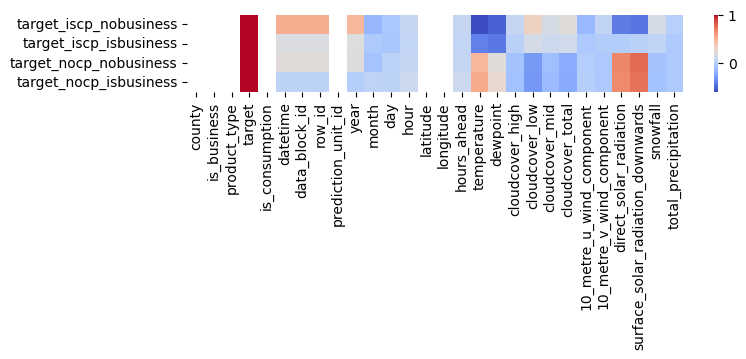

In [88]:
plt.figure(figsize=(8,1))
corr_is_consumption_no_business.rename('target_iscp_nobusiness', inplace=True)
corr_is_consumption_is_business.rename('target_iscp_isbusiness', inplace=True)
corr_no_consumption_no_business.rename('target_nocp_nobusiness', inplace=True)
corr_no_consumption_is_business.rename('target_nocp_isbusiness', inplace=True)
corr_data = pd.concat([corr_is_consumption_no_business, corr_is_consumption_is_business, corr_no_consumption_no_business, 
                       corr_no_consumption_is_business], axis=1)
sns.heatmap(corr_data.T, cmap='coolwarm')

## 总结
1、与生产电量相关性比较高的变量：**低相关**：dewpoint、cloudcover_low、cloudcover_total；**高相关**：direct_solar_radiation、surface_solar_radiation_downwards、temperature
2、与消费电量相关性比较高的变量：在商业消费用电中，dewpoint、temperature中度相关，在非商业消费用电中，temperature、dewpoint、direct_solar_radiation、surface_solar_radiation_downwards中度相关，cloudcover_low、cloudcover_total低度相关